# Get waveform clusters with WaveMap

### Steps

1. Spike sorting (21 min): `notebooks/0_method/4_sorting/silico/0_marques/sorting.ipynb`

2. Waveform extraction (23 min): `notebooks/0_method/5_postpro/silico/0_marques/waveform.ipynb`

In [26]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
from concurrent.futures import ProcessPoolExecutor

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.postpro import waveform

# SETUP PARAMETERS
MS_BEFORE = 3           # ms
MS_AFTER = 3            # ms

# silico
data_conf_sili, param_conf_sili = get_config("silico_neuropixels", "2023_10_18").values()
RAW_PATH_sili = data_conf_sili["recording"]["input"]
PREP_PATH_sili = data_conf_sili["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_sili = data_conf_sili["postprocessing"]["trace_snr"]
STUDY_FOLDER_sili = data_conf_sili["postprocessing"]["waveform"]["ground_truth"]["study"]


# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
BOX_ASPECT = 1                  # square fig
FIG_SIZE = (4,4)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 24
N_MAJOR_TICKS = 6
N_MINOR_TICKS = 12
LINEWIDTH = 1
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
tight_layout_cfg = {"pad": 0.1}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-01-17 15:31:14,727 - root - utils.py - get_config - INFO - Reading experiment config.
2024-01-17 15:31:14,743 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Build spike instances for wavemap with the units with the 5 typical profiles

In [3]:
# takes 0.4 secs
# load stuffs
Recording = si.load_extractor(PREP_PATH_sili)
WaveformExtractor = waveform.load(
    Recording,
    study_folder=STUDY_FOLDER_sili,
    ms_before=MS_BEFORE,
    ms_after=MS_AFTER,
)

In [4]:
# takes 0.8 secs


def get_unit_largest_templates_parallelized(array, cell_id):
    N_SPIKES = 6

    # get waveforms
    wfs = WaveformExtractor.get_waveforms(cell_id)

    # get this unit's templates per site
    site_templates = []
    peak_to_peak_amps = []
    for site in range(384):
        template = np.median(wfs[:, :, site].T, axis=1)
        peak_to_peak_amps.append(max(template) - min(template))
        site_templates.append(template)
    site_templates = np.array(site_templates).T

    # get six largest median spikes (templates) and concatenate as a single row instance for UMAP
    descend_sort_ix = np.argsort(peak_to_peak_amps)[::-1]
    unit_i_spike = site_templates[:, descend_sort_ix[:N_SPIKES]].T.flatten()
    return unit_i_spike

In [5]:
# test_units = WaveformExtractor.unit_ids[:10]
test_units = [796411, 911050, 165135, 1552383]

In [6]:
# takes 0.9 secs for 4 units

# compute unit's six largest templates
# (parallelized over units)
with ProcessPoolExecutor() as executor:
    site_templates = executor.map(
        get_unit_largest_templates_parallelized,
        np.arange(0, 10, 1),  # dummy not used
        test_units,
    )
site_templates = list(site_templates)

# format for wavemap (templates x (6 sites x ntimepoints))
site_templates_all = []
for unit in range(4):
    site_templates_all.append(site_templates[unit].tolist())
templates_for_wavemap = np.array(site_templates_all)

print(templates_for_wavemap.shape)

(4, 1440)


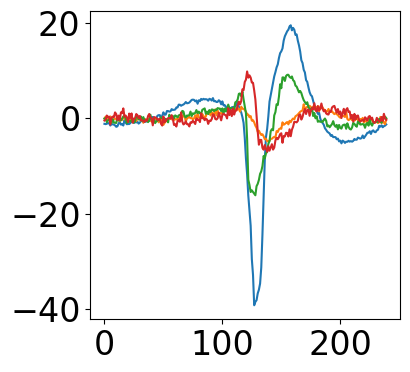

In [7]:
# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax.plot(templates_for_wavemap[0, :240])
ax.plot(templates_for_wavemap[1, :240])
ax.plot(templates_for_wavemap[2, :240])
ax.plot(templates_for_wavemap[3, :240])

### Create WaveMap waveform instance dataset for all units

In [8]:
# takes 20 secs for all (1310) units

# get all unit ids
all_units = WaveformExtractor.unit_ids

# compute unit's six largest templates
# (parallelized over units)
with ProcessPoolExecutor() as executor:
    site_templates = executor.map(
        get_unit_largest_templates_parallelized,
        np.arange(0, len(all_units), 1),  # dummy not used
        all_units,
    )
site_templates = list(site_templates)

# format for wavemap (templates x (6 sites x ntimepoints))
site_templates_all = []
for unit in range(len(all_units)):
    site_templates_all.append(site_templates[unit].tolist())
templates_for_wavemap = np.array(site_templates_all)

print(templates_for_wavemap.shape)

(1310, 1440)


### Cluster with multi-site WaveMap

In [9]:
# takes 13 secs

import sklearn.preprocessing
import os
import random
from umap import umap_ as umap
import networkx as nx
import community as community_louvain
import pandas as pd
from matplotlib import cm
from matplotlib import pyplot as plt

SPIKE_PERIOD = 240  # in timepoints
RAND_STATE = 42  # 42

# scale waveform betwene 0 and 1.
normWFs = sklearn.preprocessing.normalize(templates_for_wavemap, norm="max")

# reduce dimensionality with UMAP
np.random.seed(RAND_STATE)
os.environ["PYTHONHASHSEED"] = str(RAND_STATE)
random.seed(RAND_STATE)
reducer = umap.UMAP()
mapper = reducer.fit(normWFs)

# clustering with Louvain
G = nx.from_scipy_sparse_array(mapper.graph_)
clustering = community_louvain.best_partition(G)
clustering_solution = list(clustering.values())

# create 2D embedding
embedding = reducer.fit_transform(normWFs)

# get cluster profiles
umap_df = pd.DataFrame(embedding, columns=("x", "y"))
umap_df["waveform"] = list(normWFs)
umap_df["cluster_id"] = clustering_solution

# set profile colors
colors = np.array(
    [
        [0.13, 0.5, 0.8],  # blue
        [0, 0, 0],  # black
        [254 / 255, 235 / 255, 226 / 255],  # purple variation
        [252 / 255, 197 / 255, 192 / 255],  # purple variation
        [0.38, 0.70, 0],  # green
        [250 / 255, 159 / 255, 181 / 255],  # purple variation
        [247 / 255, 104 / 255, 161 / 255],  # purple variation
        [221 / 255, 52 / 255, 151 / 255],  # purple variation
        [174 / 255, 1 / 255, 126 / 255],  # purple variation
    ]
)

profiles = np.unique(umap_df["cluster_id"])

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back

- Plot the WaveMAP embedding

profile (count): 8
profiles: [0 1 2 3 4 5 6 7]


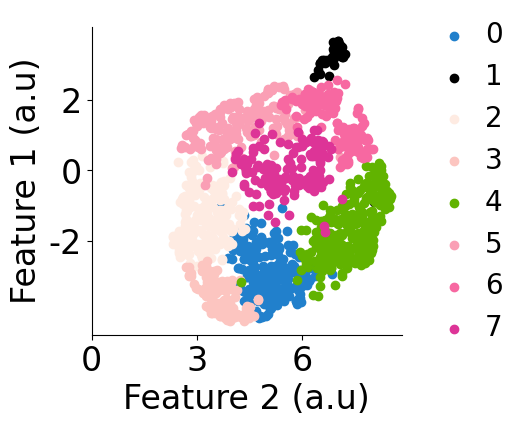

In [10]:
# plot embedding
f, ax = plt.subplots(1, figsize=FIG_SIZE)
for ix, profile_i in enumerate(profiles):
    ax.scatter(
        umap_df["x"][umap_df["cluster_id"] == profile_i].tolist(),
        umap_df["y"][umap_df["cluster_id"] == profile_i].tolist(),
        marker="o",
        color=colors[ix],
        label=profile_i,
    )

# legend
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Feature 1 (a.u)")
ax.set_xlabel("Feature 2 (a.u)")
ax.set_xticks([0, 3, 6])
ax.set_xticklabels([0, 3, 6])
ax.set_yticks([-2, 0, 2])
ax.set_yticklabels([-2, 0, 2])
plt.legend(fontsize=20, bbox_to_anchor=(1, 1.1), **legend_cfg)

# print cluster profiles

print("profile (count):", len(np.unique(umap_df["cluster_id"])))
print("profiles:", profiles)

# save fig
plt.savefig(
    "figures/2_realism/5_spikes/6_shape/pdf/marques/marques_silico_WaveMap_embedding.pdf",
    **savefig_cfg,
)
plt.savefig(
    "figures/2_realism/5_spikes/6_shape/svg/marques/marques_silico_WaveMap_embedding.svg",
    **savefig_cfg,
)

### Plot same as fig3 Paulk Nat Neurosci 2022

- first site (column) is the site with the largest peak to peak amplitude
- Second site (column) is the site with the£ second largest peak to peak amplitude

2024-01-17 15:33:12,981 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-01-17 15:33:12,997 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-01-17 15:33:13,014 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-01-17 15:33:13,029 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-01-17 15:33

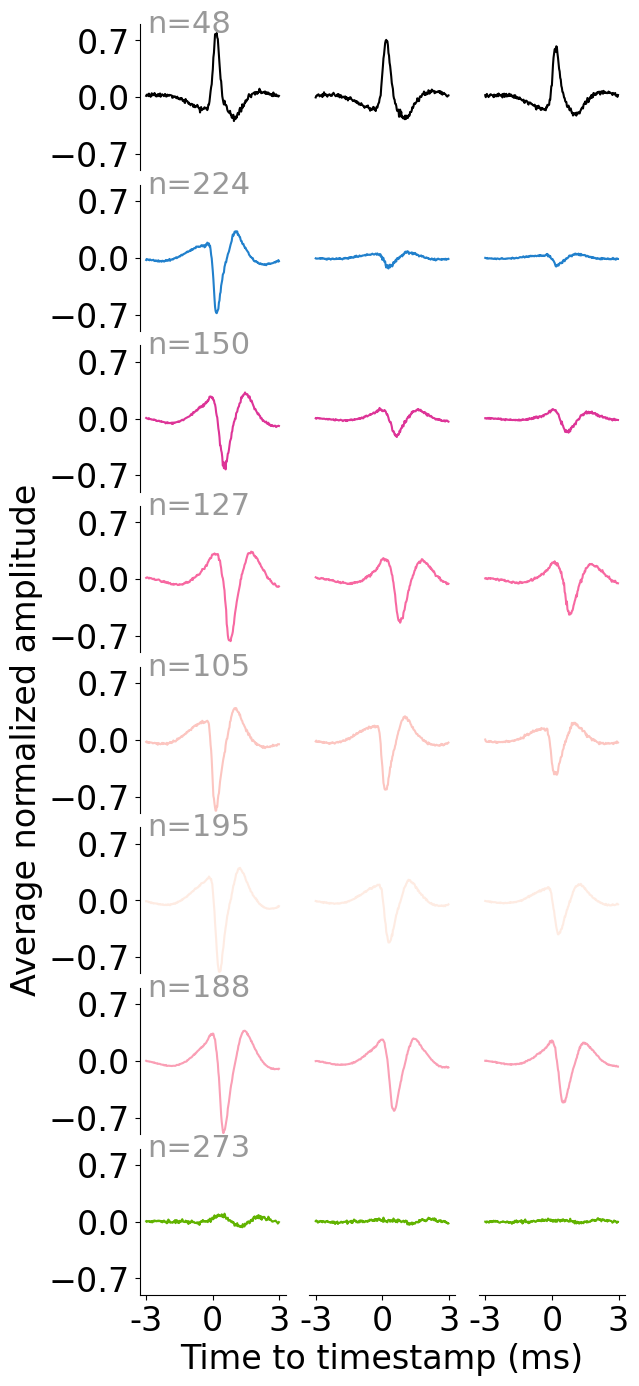

In [34]:
from collections import Counter

counts = Counter(umap_df["cluster_id"])

# order cluster profile panels
profiles = [1, 0, 7, 6, 3, 2, 5, 4]

# spike timestamp locatoon
timestamp_timepoint = SPIKE_PERIOD / 2

# setup figure
FIG_SIZE = (5 * 1.5, 11 * 1.5)
fig, axes = plt.subplots(len(profiles), 3, figsize=FIG_SIZE)

for ix, profile_i in enumerate(profiles):
    # site 1
    template = np.median(
        normWFs[umap_df["cluster_id"] == profile_i, :SPIKE_PERIOD].T, axis=1
    )

    # plot
    axes[ix, 0].plot(
        template,
        color=colors[profile_i],
    )
    axes[ix, 0].set_box_aspect(1)  # square axis
    axes[ix, 0].set_ylim([min(template), max(template)])
    axes[ix, 0].spines[["top", "right"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 0].spines[["bottom"]].set_visible(False)
    axes[ix, 0].legend(frameon=False)
    axes[ix, 0].annotate(
        "n=" + str(counts[profile_i]),
        xy=(0.05, 0.9),
        xycoords="axes fraction",
        horizontalalignment="left",
        verticalalignment="bottom",
        color=(0.6, 0.6, 0.6),
        fontsize=22,
    )
    axes[ix, 0].set_yticks([-0.7, 0, 0.7])
    axes[ix, 0].set_ylim([-0.9, 0.9])

    if ix == 4:
        axes[ix, 0].set_ylabel("Average normalized amplitude")
    axes[ix, 0].set_xticks([])
    axes[ix, 0].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 0].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 0].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])

    # site 2
    # plot
    axes[ix, 1].plot(
        np.median(
            normWFs[
                umap_df["cluster_id"] == profile_i, SPIKE_PERIOD : 2 * SPIKE_PERIOD
            ].T,
            axis=1,
        ),
        label=f"profile {profile_i} (n={str(counts[profile_i])})",
        color=colors[profile_i],
    )
    axes[ix, 1].set_box_aspect(1)  # square axis$
    axes[ix, 1].set_ylim([min(template), max(template)])
    axes[ix, 1].spines[["top", "right"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 0].spines[["bottom"]].set_visible(False)
    axes[ix, 1].set_yticks([-0.7, 0, 0.7])
    axes[ix, 1].set_ylim([-0.9, 0.9])
    axes[ix, 1].spines[["left", "right", "top"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 1].spines[["bottom"]].set_visible(False)
    axes[ix, 1].set_yticklabels([])
    axes[ix, 1].set_yticks([])
    axes[ix, 1].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
    axes[ix, 1].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 1].set_xticks([])
    axes[ix, 1].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 1].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 1].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
        axes[ix, 1].set_xlabel("Time to timestamp (ms)")

    # site 3
    # plot
    axes[ix, 2].plot(
        np.median(
            normWFs[
                umap_df["cluster_id"] == profile_i, 2 * SPIKE_PERIOD : 3 * SPIKE_PERIOD
            ].T,
            axis=1,
        ),
        label=profile_i,
        color=colors[profile_i],
    )

    axes[ix, 2].set_box_aspect(1)  # square axis
    axes[ix, 2].set_ylim([min(template), max(template)])
    axes[ix, 2].set_yticks([-0.7, 0, 0.7])
    axes[ix, 2].set_ylim([-0.9, 0.9])
    axes[ix, 2].spines[["left", "right", "top"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 2].spines[["bottom"]].set_visible(False)
    axes[ix, 2].set_yticklabels([])
    axes[ix, 2].set_yticks([])
    axes[ix, 2].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
    axes[ix, 2].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 2].set_xticks([])
    axes[ix, 2].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 2].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 2].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])

# fig.tight_layout(**tight_layout_cfg)
fig.subplots_adjust(wspace=-0.3, hspace=0.1)

# save fig
plt.savefig(
    "figures/2_realism/5_spikes/6_shape/pdf/marques/marques_silico_spike_shape.pdf",
    **savefig_cfg,
)
plt.savefig(
    "figures/2_realism/5_spikes/6_shape/svg/marques/marques_silico_spike_shape.svg",
    **savefig_cfg,
)